# Vertex AI
Use the service "Experiments" directly in vertex to tracking the results of the models trained

Examples codes to understand the tool

### 0. Packages

In [24]:
# ml packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import seaborn as sns
import pickle
import os
from dotenv import load_dotenv, find_dotenv

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# vertex gcp
from google.cloud import aiplatform as vertex_ai
from google.cloud import storage

### 1. Generate parameters, variables and artifacts to save (dummy examples)

Create very simple example to focus in show how to use the tool

#### 1.1 Generate Data

In [25]:
#### generate data ###

# parameters data
len_data = 1000
number_columns = 6
data = []
list_variables = ["240FY050.RO02" , "SGM-PI9514", "SSTRIPPING015", "SGM-PI9516" , "SGM-PI9512", "target"]


# seed
np.random.seed(42)

# generate random data
for column in range(number_columns):
    random_choise = np.random.choice(10) + 1 # amplitud
    data_column = np.random.rand(len_data)
    data_column = random_choise * data_column
    data.append(data_column)
    
# to dataframe
data = pd.DataFrame(data).T
data.columns = list_variables

# split train y test
features = list(set(list_variables) - set(['target']))
X_train, X_test, y_train, y_test = train_test_split(data[features], data['target'], test_size = 0.2, random_state=42)

print('TRAIN')
print('X_train', X_train.shape)
print('y_train', y_train.shape)

print('\nTEST')
print('X_test', X_test.shape)
print('y_test', y_test.shape)

TRAIN
X_train (800, 5)
y_train (800,)

TEST
X_test (200, 5)
y_test (200,)


#### 1.2 EDA
Generate a plot of the data to save as results of EDA with this data. Obs: this is only and example, the idea is show that can save any thing as artifact, including images

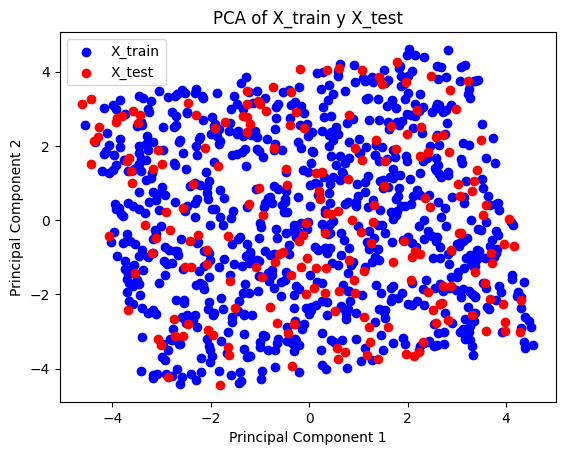

In [26]:
# ONLY EXAMPLE dimensionaly reduction to 2 dimensions and show the "change of distribution between train and test"

# train pca
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# plot
plot_uri_local = 'pca_plot.png'
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c='blue', label='X_train')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c='red', label='X_test')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('PCA of X_train y X_test')
plt.savefig(plot_uri_local)
plt.show()

#### 1.3 Train model

In [27]:
#### train model ####
model = LinearRegression()
#model = RandomForestRegressor(random_state = 42)
model.fit(X_train, y_train)



#### predicción y evaluación ####

### RMSE
rmse_train = mean_squared_error(y_train, 
                                model.predict(X_train),
                                squared = False)

rmse_test = mean_squared_error(y_test, 
                               model.predict(X_test),
                               squared = False)


### R2
r2_score


r2_train = r2_score(y_train,
                   model.predict(X_train))

r2_test = r2_score(y_test,
                   model.predict(X_test))

#### 1.4 Generate outputs to save
In this example, the outputs to save are genated in the final step, but it can be genrated while the code is running and use its python variables generated

##### Parameters

In [28]:
# print previous parameter defined - list tags
print('list tags:\n', list_variables)

list tags:
 ['240FY050.RO02', 'SGM-PI9514', 'SSTRIPPING015', 'SGM-PI9516', 'SGM-PI9512', 'target']


In [29]:
# type of model trained - define a string with the name
model_type = "RF"
model_type

'RF'

In [30]:
# dates of training
start_train = "2020-01-01"
end_train = "2022-12-01"

##### Metrics

In [31]:
# print metrics
print('rmse_train: ', rmse_train)
print('rmse_test: ', rmse_test)
print('r2_train: ', r2_train)
print('r2_test: ', r2_test)

rmse_train:  1.4387312960740368
rmse_test:  1.4632467048976407
r2_train:  0.007202043897398536
r2_test:  -0.011984948488191094


##### Artifacts

In [32]:
# generate a pickle with the model
model_uri_local = 'model.pkl'
with open(model_uri_local, 'wb') as file:
    pickle.dump(model, file)

In [33]:
# generar artefacto data csv y borrar del local
data_uri_local = 'data.csv'
data.to_csv(data_uri_local)

### 2. Registry Experiment Vertex AI
- Documentation codes Vertex: https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Experiment

Notebooks with examples:
- Oficial repo gcp: https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/experiments/vertex_ai_model_experimentation.ipynb
- medium post: https://medium.com/google-cloud/machine-learning-experiment-tracking-with-vertex-ai-8406f8d44376



-------
**IMPORTANT**

Previously vertex tensorboard has a high cost and everyone recommend to not use it. But now vertex tensorboard is cheaper, so is highly recommended use it to analyse end evaluate the models trained (IN ADDITION that was not possible save artifacts in the experiments without having a vertex tensorboard instance created)

In [34]:
# show version of vertex used. The version of vertex is constantly updated
!pip show google-cloud-aiplatform

Name: google-cloud-aiplatform
Version: 1.35.0
Summary: Vertex AI API client library
Home-page: https://github.com/googleapis/python-aiplatform
Author: Google LLC
Author-email: googleapis-packages@google.com
License: Apache 2.0
Location: d:\anaconda\envs\data-science-python-3-10\lib\site-packages
Requires: google-api-core, google-cloud-bigquery, google-cloud-resource-manager, google-cloud-storage, packaging, proto-plus, protobuf, shapely
Required-by: 


In [35]:
# PARAMETERS GCP

# get environment variables from .env - only necesary using a jupyter notebook
load_dotenv(find_dotenv())

# read env variables
PROJECT_GCP = os.environ.get("PROJECT_GCP", "")
LOCATION_GCP = os.environ.get("LOCATION_GCP", "")
BUCKET_NAME = os.environ.get("BUCKET_NAME", "")

In [36]:
# PARAMETERS CREATE AN EXPERIMENT IN VERTEX AI. # obs: In names only are accepted '[a-z0-9][a-z0-9-]{0,127}'
EXPERIMENT_NAME = 'intro3-experiment-vertex'
EXPERIMENT_DESCRIPTION = 'Introduction to save experiment in vertex'

#### 2.1 Create experiment
Create an experiment and inside of this, different runs are created to save the results of diferents models trained.
Step:
- create vertex tensorboard instance
- create vertex experiment associated with the tensorboard instance created

Obs:
- The method vertex_ai.init() set the experiment if this exists and if donesn't exist, it is created. Also, when is set the tensorboard it is created if it doesn't exist
- documentation: https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Tensorboard#google_cloud_aiplatform_Tensorboard_create

OBS IMPORTANT:
- Tensorboard.create create always work creating a new tensorboard instance with the same display name but different ID

##### 2.1.1 ONLY ONCE. CREATE TENSORBOARD INSTANCE FOR THIS EXPERIMENT
Because, each time is calling this code a new tensorboard instance is created with the same display name and different id (resource_name)

In [37]:
# create tensorboard instace - only the first time

"""
experiment_tensorboard = vertex_ai.Tensorboard.create(display_name = f'tensorboard-{EXPERIMENT_NAME}',
                                                      description = f'tensorboard-{EXPERIMENT_DESCRIPTION}',
                                                        project = PROJECT_GCP,
                                                        location = LOCATION_GCP
                                                     )
experiment_tensorboard
"""

"\nexperiment_tensorboard = vertex_ai.Tensorboard.create(display_name = f'tensorboard-{EXPERIMENT_NAME}',\n                                                      description = f'tensorboard-{EXPERIMENT_DESCRIPTION}',\n                                                        project = PROJECT_GCP,\n                                                        location = LOCATION_GCP\n                                                     )\nexperiment_tensorboard\n"

#### 2.1.2 Set the experiment
If the experiment doesn't exist, it is created. And if it exists set the experiment

In [38]:
# IMPORTANT: THE DISPLAY NAME D0ESN'T SHOWED, ONLY THE ID
vertex_ai.Tensorboard.list(project = PROJECT_GCP,
                           location = LOCATION_GCP
                          )

 resource name: projects/724348686027/locations/us-east1/tensorboards/2822208853989392384,
 resource name: projects/724348686027/locations/us-east1/tensorboards/5128051863203086336,
 resource name: projects/724348686027/locations/us-east1/tensorboards/5389260641590575104]

In [39]:
# GET tensorboard instance created FILTERING by display name 
# return a list of the instance doesn't exist return a empty list

id_tensorboard_vertex = vertex_ai.Tensorboard.list(
    #filter = f'display_name="tensorboard-intro3-experiment-vertex"',
    filter = f'display_name="tensorboard-{EXPERIMENT_NAME}"',
    project = PROJECT_GCP,
    location = LOCATION_GCP
)[0]

id_tensorboard_vertex

resource name: projects/724348686027/locations/us-east1/tensorboards/2822208853989392384

In [41]:
# set experiment (or created if it doesn't exist - automatically)
vertex_ai.init(
    experiment = EXPERIMENT_NAME,
    experiment_description = EXPERIMENT_DESCRIPTION,
    experiment_tensorboard = id_tensorboard_vertex,
    project = PROJECT_GCP,
    location = LOCATION_GCP,
    )

In [ ]:
stop

#### 2.2 Create Run
create a run were save the results of the model trained

In [44]:
# PARAMETERS CREATE A RUN IN A VERTEX AI "EXPERIMENT"
RUN_NAME = "run-5"

In [45]:
# create a run
vertex_ai.start_run(RUN_NAME)

Associating projects/724348686027/locations/us-east1/metadataStores/default/contexts/intro3-experiment-vertex-run-5 to Experiment: intro3-experiment-vertex


#### 2.3 Save parameters

In [ ]:
# define params to save. In a dicctionary
params_to_save = {
    'learning_rate': 0.01,
    'dropout_rate': 0.02,
    'list_features': str(list_variables), # only support strings
    'model_type': model_type,
    'start_train': start_train,
    'end_train': end_train
}

# save parameters
vertex_ai.log_params(params_to_save)

#### 2.4 Save metrics

In [ ]:
# define metrics to save. In a dicctionary
metrics_to_save = {
    'rmse_train': rmse_train,
    'rmse_test': rmse_test,
    'r2_train': r2_train,
    'r2_test': r2_test
}

# save metrics
vertex_ai.log_metrics(metrics_to_save)

In [ ]:
#### obs: the metrics can be replaced any times that you want/need
metrics_to_save = {
    'rmse_train': rmse_train,
    'rmse_test': rmse_test,
    'r2_train': r2_train + 10,
    'r2_test': r2_test + 56
}

# save metrics 
vertex_ai.log_metrics(metrics_to_save)

In [ ]:
### obs: in adition you can add new metrics without loss the previous values
metrics_to_save = {
    'loss_train': 0.0001,
    'loss_test': 3000
}

# save metrics
vertex_ai.log_metrics(metrics_to_save)

**OBS: It is also possible to modify the run parameters**

#### 2.5 Save time series
Save metrics during the training phase. For example, acc, loss, etc. in each step of training the NN.

These metrics must be stored in a vertex tensorboa).

In [ ]:
### EXAMPLE CODE TO SAVE METRICS OF EACH EPOCH OF TRAINNING THE MODEL

vertex_ai.log_time_series_metrics({"mse": 2500.00, "rmse": 50.00})
vertex_ai.log_time_series_metrics({"mse": 2600.00, "rmse": 60.00})
vertex_ai.log_time_series_metrics({"mse": 2700.00, "rmse": 70.00})
vertex_ai.log_time_series_metrics({"mse": 2800.00, "rmse": 100.00})
vertex_ai.log_time_series_metrics({"mse": 5.00, "rmse": 2.00})
vertex_ai.log_time_series_metrics({"mse": 2.00, "rmse": 1.00})

#### 2.6 Save artifacts
- Documentation save artifacts saved in GCS in menu "metadata" of vertex: https://cloud.google.com/python/docs/reference/aiplatform/1.15.0/google.cloud.aiplatform.Artifact

- Documentation how to link artifacts saved in "metadata" menu with artifacts in "run" of "experiments" in vertex. Metadata Execution resource for Vertex AI: https://cloud.google.com/python/docs/reference/aiplatform/1.15.0/google.cloud.aiplatform.Execution


- Artifacts types. There are differents types of artifact: System.Dataset, system.Model, system.Artifact


- The main idea TO SAVE ARTIFACT IN THE RUN is:

-- save artifact locally
  
-- save artifact in GCS
  
-- link the artifact in GCS with vertex metadata
  
-- link vertex metadata with artifacts saved in a run (experiments vertex)

In [ ]:
### ----> define the path in GCS where the artifacts will be saved
data_uri = f'gs://{BUCKET_NAME}/data.csv'
model_uri = f'gs://{BUCKET_NAME}/model.pkl'
plot_uri = f'gs://{BUCKET_NAME}/pca_plot.png'

In [ ]:
# -----> save the local artifacts in GCS

def save_local_to_gcs(uri_gcs, uri_local):
    """
    Save a locally file onto GCS.
    Args:
        uri_gcs (string): path in gcs where the local file will be saved
        uri_local (strring). path in local where the local file was saved

    Return
        nothing
    """

    blob = storage.blob.Blob.from_string(uri_gcs, client=storage.Client())
    blob.upload_from_filename(uri_local)


# save from local to gcs
save_local_to_gcs(uri_gcs = plot_uri, 
                  uri_local = plot_uri_local)

save_local_to_gcs(uri_gcs = data_uri, 
                  uri_local = data_uri_local)

save_local_to_gcs(uri_gcs = model_uri, 
                  uri_local = model_uri_local)

In [ ]:
### -----> create a metadata file in vertex menu "metadata" will be used to registry the artifacts in GCS into metdata


# crear un archivo metadata de vertex que apunta al archivo en GCS subido - type of artifact: system.artifact
artifact_metadata = vertex_ai.Artifact.create(
    schema_title = "system.Artifact", 
    uri = plot_uri, 
    display_name = "plot-image", # nombre con el que se muestra en el menu "metadata"
    description = "description-plot-image",
    
    resource_id = f"plot-image---{EXPERIMENT_NAME}-{RUN_NAME}"  # nombre con el que se muestra en el menu "artifact del run del experimento" de vertex. No acepta espacios
    )


# crear un archivo metadata de vertex que apunta al archivo en GCS subido - tpye of artifact: system.dataset
data_metadata = vertex_ai.Artifact.create(
    schema_title = "system.Dataset", 
    uri = data_uri, 
    display_name = "data csv",
    description = "description data csv",
    resource_id = f"data---{EXPERIMENT_NAME}-{RUN_NAME}"
    )


# crear archivo metadata de vertex que apunte al archivo en GCS subido - type of artifact: model.pkl
model_artifact = vertex_ai.Artifact.create(
    schema_title = 'system.Model',
    uri = model_uri,
    display_name = 'model',
    description = "description model",
    resource_id = f"model---{EXPERIMENT_NAME}-{RUN_NAME}"
)

In [ ]:
#### Link "artifacts in metadata" with "artifacts in the run"

# create executions
executions = vertex_ai.start_execution(
    schema_title="system.ContainerExecution", 
    display_name='REGISTRO DE ARTIFACTS'
)

# define 'input artifacts' such as parameters, data, etc
executions.assign_input_artifacts([data_metadata, artifact_metadata])

# define 'output artifacts' -> model
executions.assign_output_artifacts([model_artifact])

**Obs: It is not necessary define always intup and output artifact**

#### 2.7 End run

In [ ]:
### terminar run
vertex_ai.end_run()

#### 2.8 Remove local files

In [ ]:
# remove artifacts saved locally
os.remove(model_uri_local)
os.remove(data_uri_local)
os.remove(plot_uri_local)

In [ ]:
stop

### 3. Compare runs
Given the experiment name, extract in a dataframe the information of each runs in this experiment. Use this information to decide which is the best model trained

In [ ]:
# info all runs of a experiment - way 1
df_results_experiments = vertex_ai.get_experiment_df(EXPERIMENT_NAME)

# info all runs of a experiment - way 2
# my_experiment = vertex_ai.Experiment(EXPERIMENT_NAME)
# df_results_experiments = my_experiment.get_data_frame()

df_results_experiments

### 4. Get best model
Give the dataframe with all the runs of a experiment. Get the best model trained and get its parameters, metrics and artifacts

In [ ]:
# get the info of best model trained considering certain metrics
target_metric = 'metric.r2_test'
row_max_r2_test = df_results_experiments.loc[df_results_experiments[target_metric].idxmax()]
row_max_r2_test

In [ ]:
# get run_name best model trained
run_name_best = row_max_r2_test['run_name']
run_name_best

In [ ]:
# connect to best run given the "run_name"
run_best = vertex_ai.ExperimentRun.get(run_name_best, experiment = EXPERIMENT_NAME)
run_best

In [ ]:
# get artifacts
run_best.get_artifacts()

In [ ]:
# example reading an artifact
pd.read_csv(run_best.get_artifacts()[1].uri)

In [ ]:
run_best.get_metrics()

In [ ]:
run_best.get_params()

In [ ]:
run_best.get_experiment_models()

In [ ]:
run_best.get_time_series_data_frame()